In [31]:
from datasets import load_dataset
import pandas as pd
import spacy as sp
import numpy as np

import re
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.corpora import Dictionary
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [32]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shafayetulislam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
custom_stop_words = {
    'like', 'feel', 'want', 'know', 'time', 'never', 'really', 'think', 'get', 'always',
    'say', 'says', 'ask', 'see', 'done', 'deal', 'talk', 'talking', 'remember',
    'help', 'therapy', 'therapist', 'counselor', 'counseling', 'doctor', 'names', 'past', 'years', 'problem', 'relationship',
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'they', 'them', 'their', 'theirs',
    'mental', 'health', 'anxiety', 'depression', 'disorder', 'stress', "i'm"
}
stop_words.update(custom_stop_words)

In [34]:
# initialsation

# lemmatizer
lemmatizer = WordNetLemmatizer()

In [35]:
# view the col context fully...
pd.set_option('display.max_colwidth', None)

In [36]:
# load dataset from huggingface
ds = load_dataset("Amod/mental_health_counseling_conversations")

In [37]:
# convert dataset to pandas_data_frame
df = ds['train'].to_pandas()

In [38]:
# save the raw data in csv for efficient loading later.
df.to_csv("mental_health_counseling_conversations.csv", sep='\t', encoding='utf-8')

In [39]:
df.head()

,Context,Response
0,"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n How can I change my feeling of being worthless to everyone?","If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media. Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief that if someone doesn't feel good about themselves that this is somehow terrible.Bad feelings are part of living. They are the motivation to remove ourselves from situations and relationships which do us more harm than good.Bad feelings do feel terrible. Your feeling of worthlessness may be good in the sense of motivating you to find out that you are much better than your feelings today."
1,"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n How can I change my feeling of being worthless to everyone?","Hello, and thank you for your question and seeking advice on this. Feelings of worthlessness is unfortunately common. In fact, most people, if not all, have felt this to some degree at some point in their life. You are not alone. Changing our feelings is like changing our thoughts - it's hard to do. Our minds are so amazing that the minute you change your thought another one can be right there to take it's place. Without your permission, another thought can just pop in there. The new thought may feel worse than the last one! My guess is that you have tried several things to improve this on your own even before reaching out on here. People often try thinking positive thoughts, debating with their thoughts, or simply telling themselves that they need to ""snap out of it"" - which is also a thought that carries some self-criticism. Some people try a different approach, and there are counselors out there that can help you with this. The idea is that instead of trying to change the thoughts, you change how you respond to them. You learn skills that allow you to manage difficult thoughts and feelings differently so they don't have the same impact on you that they do right now. For some people, they actually DO begin to experience less hurtful thoughts once they learn how to manage the ones they have differently. Acceptance and Commitment Therapy may be a good choice for you. There is information online and even self-help books that you can use to teach you the skills that I mentioned. Because they are skills, they require practice, but many people have found great relief and an enriched life by learning them. As for suicidal thoughts, I am very glad to read that this has not happened to you. Still, you should watch out for this because it can be a sign of a worsening depression. If you begin to think about this, it is important to reach out to a support system right away. The National Suicide Prevention Lifeline is 1-800-273-8255. The text line is #741741. I hope some other colleagues will provide you more suggestions. Be well...Robin Landwehr, DBH, LPCC"
2,"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n How

In [40]:
df.shape

(3512, 2)

In [41]:
# in this dataset, for the same context there are different responses. As the important part for us is the context, 
# and not the response, let's take only the unique contexts for topic modelling
unique_contexts = df['Context'].drop_duplicates()

In [42]:
# took the unique context values.
unique_contexts.shape

(995,)

In [43]:
# converting to the list
unique_contexts_list = unique_contexts.tolist()

In [44]:
unique_contexts_list[:5]

["I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n   How can I change my feeling of being worthless to everyone?",
 'I have so many issues to address. I have a history of sexual abuse, I’m a breast cancer survivor and I am a lifetime insomniac.    I have a long history of depression and I’m beginning to have anxiety. I have low self esteem but I’ve been happily married for almost 35 years.\n   I’ve never had counseling about any of this. Do I have too many issues to address in counseling?',
 'I have been feeling more and more down for over a month. I have started having trouble sleeping due to panic attacks, but they are almost never triggered by something that I know of.',
 'I’m facing severe depression and anxiety and I just feel like I’m going through a lot. This rea

In [45]:
len(unique_contexts_list)

995

In [46]:
def preprocess(text):
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Split on whitespace
    tokens = text.split()
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords

    # Apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # remove short words
    tokens = [word for word in tokens if len(word) > 2] 
    
    return tokens

In [47]:
preprocessed_res = preprocess(unique_contexts_list[0])
print(unique_contexts_list[0])
print()
print(preprocessed_res)

I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?

['going', 'thing', 'feeling', 'barely', 'sleep', 'nothing', 'worthless', 'tried', 'contemplated', 'suicide', 'wanted', 'fix', 'issue', 'around', 'change', 'feeling', 'worthless', 'everyone']


In [59]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # For Gensim models
from pyLDAvis import prepare

def visualize_pyLDAVis_sklearn(lda_model, dtm, vectorizer):
    """
    Visualize the LDA topics using pyLDAVis for sklearn LDA models.
    
    Parameters:
    - lda_model: The trained LDA model (from sklearn).
    - dtm: Document-term matrix (output of `TfidfVectorizer` or similar).
    - vectorizer: The vectorizer used to create the DTM (e.g., `TfidfVectorizer`).
    """
    # Convert LDA components into the format required by pyLDAVis
    data = {
        "topic_term_dists": lda_model.components_ / lda_model.components_.sum(axis=1)[:, None],
        "doc_topic_dists": lda_model.transform(dtm),
        "doc_lengths": dtm.sum(axis=1).A1,
        "vocab": vectorizer.get_feature_names_out(),
        "term_frequency": dtm.sum(axis=0).A1
    }

    # Prepare the visualization
    vis_data = prepare(**data)

    # Save visualization to an HTML file
    pyLDAvis.save_html(vis_data, 'lda_visualization.html')
    print("Visualization saved to lda_visualization.html")

In [69]:
def perform_topic_modeling(texts, n_topics=10):
    """
    Perform topic modeling using both LDA and NMF
    """
    
    # Preprocess texts
    processed_texts = [preprocess(text) for text in texts]

    # Convert tokenized texts back to strings for vectorizer
    processed_texts_as_strings = [' '.join(text) for text in processed_texts]
    
    # Create TF-IDF matrix
    vectorizer = TfidfVectorizer(
        max_features=1000,
        min_df=2,
        max_df=0.95
    )
    dtm = vectorizer.fit_transform(processed_texts_as_strings)
    
    # Perform LDA
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20
    )
    
    # Fit LDA model
    doc_topics = lda_model.fit_transform(dtm)
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Get top words for each topic
    n_top_words = 10
    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
        topics.append({
            'topic_id': topic_idx,
            'words': top_words
        })
    
    # Create dictionary and corpus
    # dictionary = Dictionary(processed_texts)
    # corpus = [dictionary.doc2bow(text) for text in processed_texts]
    # visualize_interactive_lda(lda_model, corpus, dictionary)

    
    return {
        'doc_topics': doc_topics,
        'topics': topics,
        'model': lda_model,
        'vectorizer': vectorizer,
        'processed_texts': processed_texts
    }

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_word_count_distribution(processed_texts):
    # Calculate word counts for each document
    word_counts = [len(doc) for doc in processed_texts]

    # Plot frequency distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(word_counts, bins=30, kde=True, color='blue')
    plt.title('Frequency Distribution of Word Counts in Documents')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()

In [62]:
import pandas as pd

def visualize_word_count_by_topic(processed_texts, doc_topics):
    # Calculate word counts for each document
    word_counts = [len(doc) for doc in processed_texts]

    # Determine the dominant topic for each document
    dominant_topics = doc_topics.argmax(axis=1)  # Get index of the highest topic probability

    # Create a DataFrame for visualization
    data = pd.DataFrame({
        'Word Count': word_counts,
        'Dominant Topic': dominant_topics
    })

    # Plot word count distribution by dominant topic
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=data, x='Dominant Topic', y='Word Count', palette='Set2')
    plt.title('Distribution of Document Word Counts by Dominant Topic')
    plt.xlabel('Dominant Topic')
    plt.ylabel('Word Count')
    plt.show()

In [63]:
def visualize_word_clouds(lda_model, vectorizer, n_topics, n_top_words=20):
    from math import ceil
    
    # Get feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Calculate number of rows needed for the grid
    n_cols = 2  # Fixed to 2 columns
    n_rows = ceil(n_topics / n_cols)  # Calculate rows based on the number of topics
    
    # Set up a subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows), sharex=False, sharey=False)
    axes = axes.flatten()  # Flatten for easy indexing

    for topic_idx, topic in enumerate(lda_model.components_):
        # Extract top N words and their weights for the topic
        top_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]}
        
        # Generate the word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='tab10'
        ).generate_from_frequencies(top_words)
        
        # Plot the word cloud in the corresponding subplot
        ax = axes[topic_idx]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Topic {topic_idx + 1}", fontsize=14)

    # Hide extra subplots (if any)
    for ax in axes[len(lda_model.components_):]:
        ax.axis("off")

    plt.tight_layout()
    plt.suptitle("Word Clouds of Top Keywords in Each Topic", fontsize=16, y=1.02)
    plt.show()

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_word_clouds(lda_model, vectorizer, n_topics, n_top_words=20):
    # Get feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Set up a subplot grid
    fig, axes = plt.subplots(2, (n_topics + 1) // 2, figsize=(16, 8), sharex=False, sharey=False)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(lda_model.components_):
        # Extract top N words and their weights for the topic
        top_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]}
        
        # Generate the word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='tab10'
        ).generate_from_frequencies(top_words)
        
        # Plot the word cloud in the corresponding subplot
        ax = axes[topic_idx]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Topic {topic_idx + 1}", fontsize=14)

    # Remove extra subplots if topics < total grid slots
    for ax in axes[n_topics:]:
        ax.axis("off")

    plt.tight_layout()
    plt.suptitle("Word Clouds of Top Keywords in Each Topic", fontsize=16, y=1.02)
    plt.show()

In [65]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_tsne_clusters(doc_topics, n_topics):
    """
    Visualize t-SNE Clustering Chart for Topic Modeling
    
    Parameters:
    - doc_topics: Document-topic distribution matrix (output of LDA `fit_transform`).
    - n_topics: Number of topics in the model.
    """
    # Perform t-SNE dimensionality reduction
    tsne_model = TSNE(
        n_components=2, 
        perplexity=30, 
        n_iter=1000, 
        random_state=42
    )
    tsne_results = tsne_model.fit_transform(doc_topics)

    # Assign colors for topics
    colors = plt.cm.tab10(np.linspace(0, 1, n_topics))
    
    # Get the dominant topic for each document
    dominant_topics = np.argmax(doc_topics, axis=1)
    
    # Create the scatter plot
    plt.figure(figsize=(12, 8))
    for topic_idx in range(n_topics):
        # Filter points for the current topic
        topic_points = tsne_results[dominant_topics == topic_idx]
        plt.scatter(
            topic_points[:, 0], 
            topic_points[:, 1], 
            s=50, 
            c=[colors[topic_idx]], 
            label=f"Topic {topic_idx + 1}", 
            alpha=0.6
        )

    # Add labels and legend
    plt.title("t-SNE Clustering of Documents by Topic", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend(title="Topics", fontsize=10)
    plt.grid(alpha=0.2)
    plt.show()

In [66]:
def analyze_mental_health_topics(text_list):
    
    print("Starting analysis...")
    results = perform_topic_modeling(text_list, n_topics=10)

    # Visualize word count distribution
    visualize_word_count_distribution(results['processed_texts'])

    # Visualize word count distribution by dominant topic
    visualize_word_count_by_topic(results['processed_texts'], results['doc_topics'])

    # worl cloud visualisation
    visualize_word_clouds(results['model'], results['vectorizer'], n_topics=10)

    # Visualize t-SNE Clustering
    visualize_tsne_clusters(results['doc_topics'], n_topics=10)

    
        
    return results

Starting analysis...
Visualization saved to lda_visualization.html


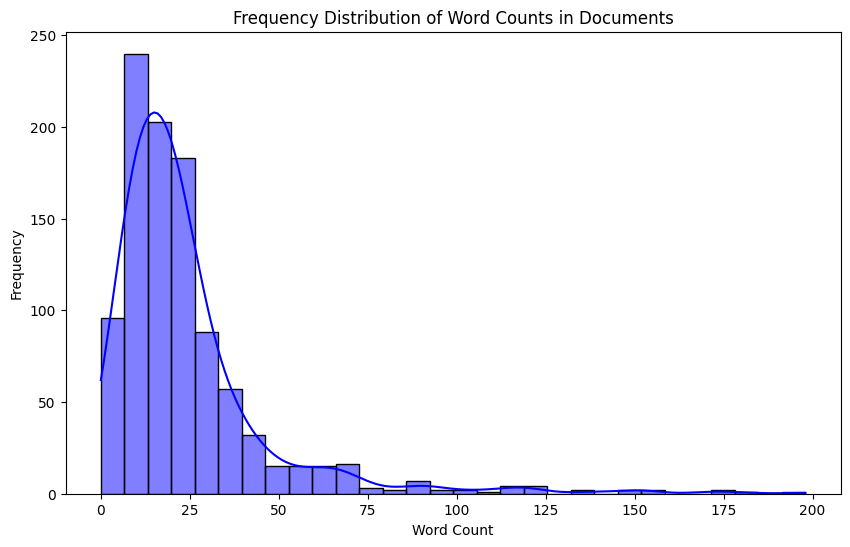

/var/folders/56/8wy2gydd3lz4lx2k9755q6rm0000gn/T/ipykernel_57550/10135665.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Dominant Topic', y='Word Count', palette='Set2')


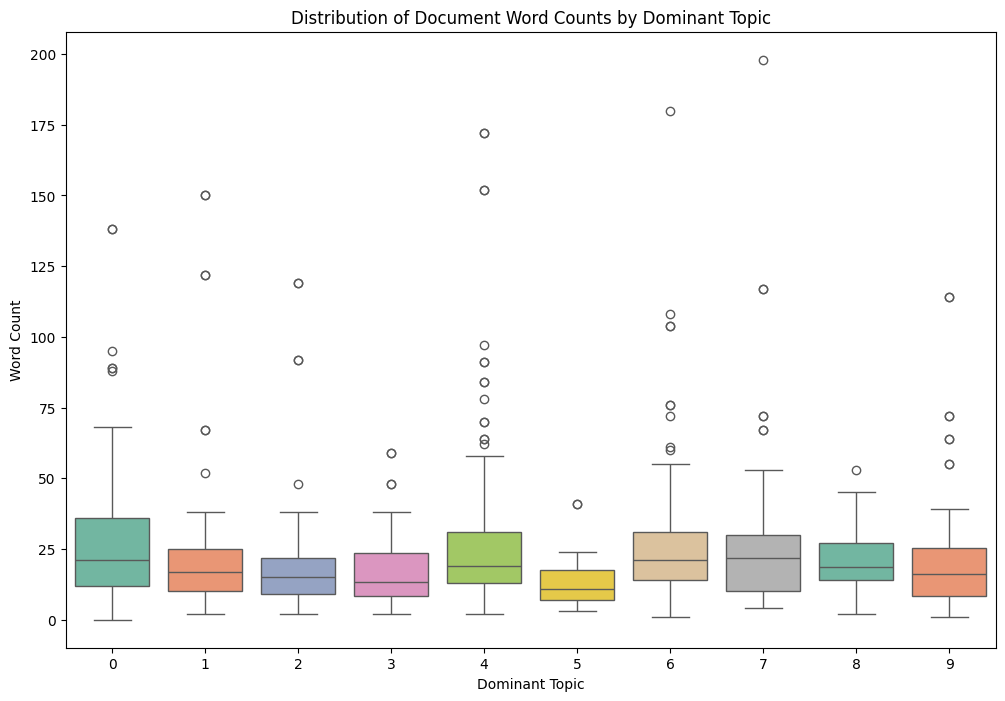

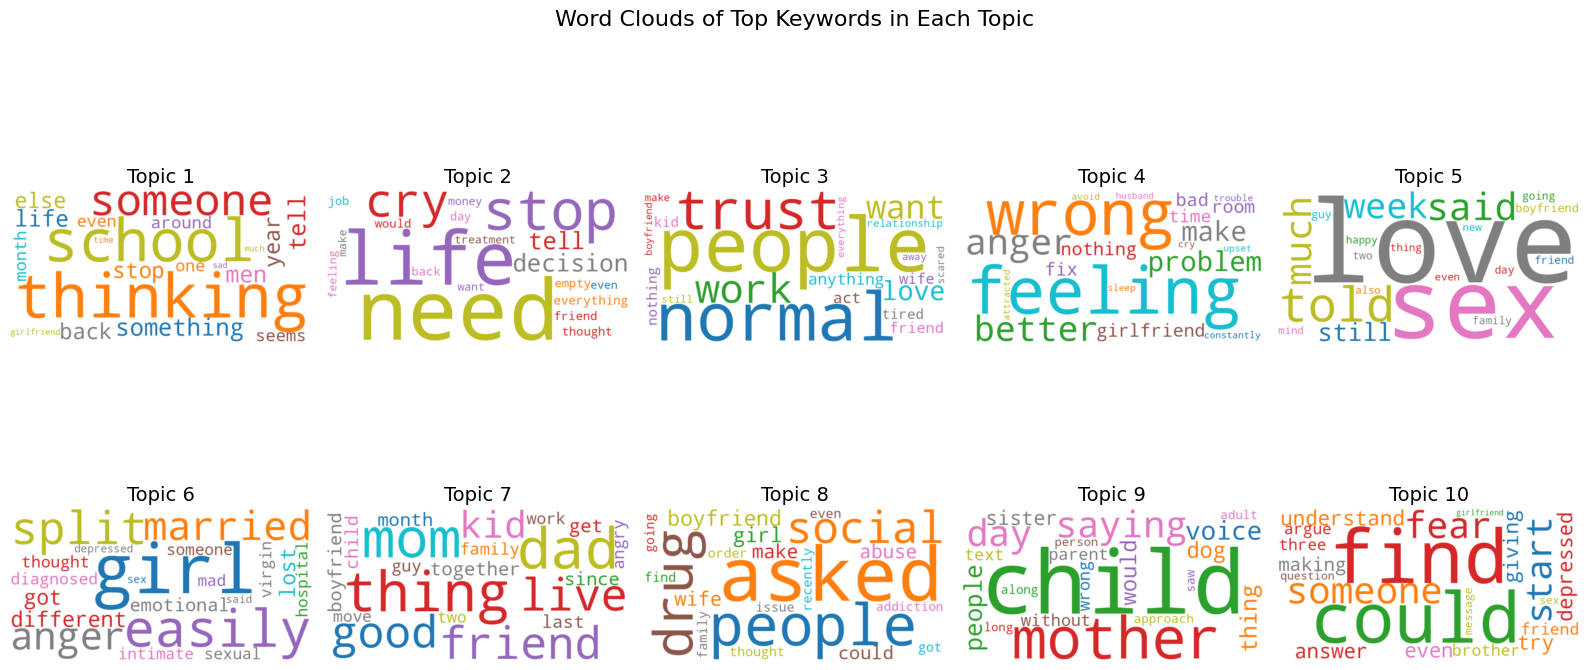

/Users/shafayetulislam/Documents/mentalHealthTM/mentalHealthTMenv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


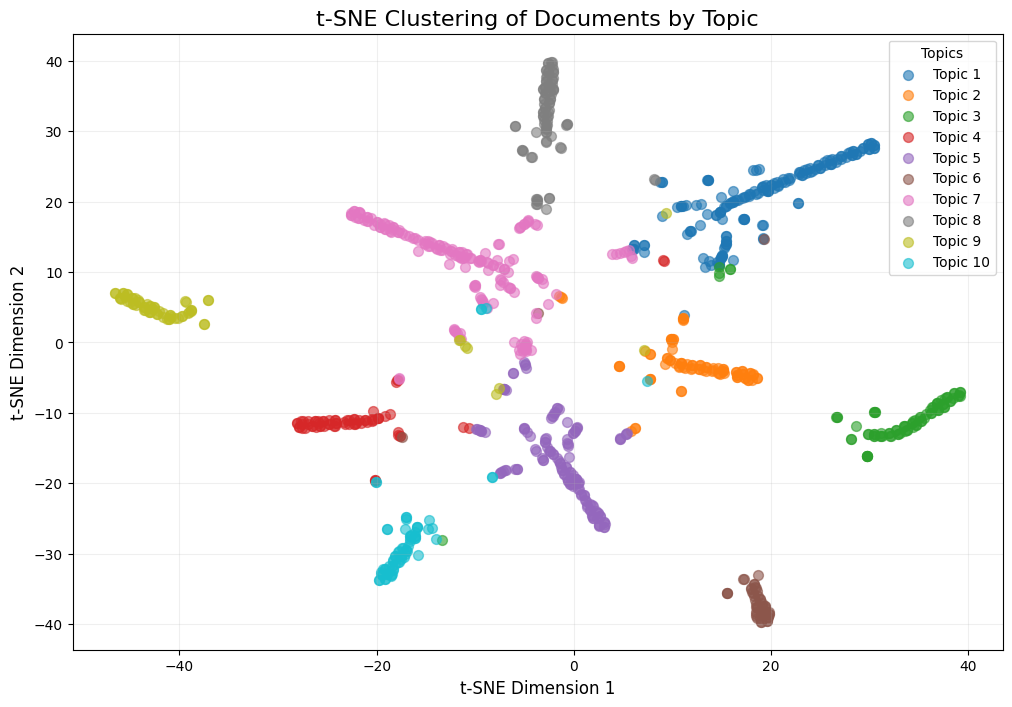

In [67]:
results = analyze_mental_health_topics(unique_contexts_list)

In [57]:

# visualize

# Frequency Distribution of Word Counts in Documents
# Distribution of Document Word Counts by Dominant Topic

# Word Clouds of Top N Keywords in Each Topic

# What are the most discussed topics in the documents?

# t-SNE Clustering Chart

# pyLDAVis

In [68]:
for topic in results['topics']:
        print(f"\nTopic {topic['topic_id'] + 1}:")
        print(", ".join(topic['words']))


Topic 1:
thinking, school, someone, something, tell, men, life, back, stop, year

Topic 2:
need, life, stop, cry, decision, tell, everything, would, friend, empty

Topic 3:
people, normal, trust, work, want, love, anything, act, friend, wife

Topic 4:
feeling, wrong, anger, better, problem, make, girlfriend, fix, room, nothing

Topic 5:
love, sex, told, said, much, week, still, boyfriend, guy, day

Topic 6:
girl, easily, split, married, anger, different, lost, got, emotional, diagnosed

Topic 7:
dad, thing, mom, friend, live, good, kid, together, get, boyfriend

Topic 8:
asked, people, drug, social, boyfriend, girl, wife, abuse, make, could

Topic 9:
child, mother, saying, day, voice, people, thing, would, dog, sister

Topic 10:
find, could, someone, fear, start, understand, depressed, even, answer, try
